### Experiment: Navigation level - CSCG vs HMM

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from pathlib import Path

from hippo.agents.hmm_agent import HMMAgent
from hippo.environments.action_perception import action_perception_loop
from hippo.environments.sequences import EvaluationSequences3x3WMaze
from hippo.environments.w_maze import get_wmaze
from hippo.agents.replay_agent import ReplayAgent
from hippo import load_object
from hippo import get_data_path

import matplotlib.pyplot as plt

from copy import copy

pygame 2.5.2 (SDL 2.28.3, Python 3.11.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import hippo

store_path = Path(hippo.__file__).parent.parent / "data/results/experiment-hmm"
store_path.mkdir(exist_ok=True, parents=True)

In [5]:

from hippo.visualization.maze import add_wmaze_plot
from hippo.visualization import visualize_trajectories

import matplotlib.patches as mpatches

def _replay_sequence(goal_index, start_index, sequences):
    env = get_wmaze(sequences.start_positions[start_index])

    actions = sequences.action_sequences[goal_index][start_index]
    run_logs = action_perception_loop(
        env,
        ReplayAgent(copy(actions) + [2]),
        len(actions) + 1,
        record_frames=False,
        record_agent_info=False,
        progress_bar=False
    )
    return run_logs

def _decode_belief(agent_ui, run_logs):
    agent_ui.reset()
    for o, a in zip(run_logs["obs"], run_logs["action"]):
        qs = agent_ui.replay_step(o, a)
    # Add zeroth dimension because of pymdp legacy: TODO refactor it all
    return [np.array([qs])]

def generate_trajectory_end_state(agent_ui):
    sequences = EvaluationSequences3x3WMaze()

    trajectories = []
    for goal_index in sequences.goal_positions.keys():
        for start_index in sequences.start_positions.keys():
            # Replay the actions of the sequence
            run_logs = _replay_sequence(goal_index, start_index, sequences)
            # Use the logs to decode into a belief over the end state
            beliefs = _decode_belief(agent_ui, run_logs)

            # Store the intermediate results in a trajectories dictionary
            trajectories.append(
                {
                    "pose": run_logs["pose"],
                    "goal_index": goal_index,
                    "start_index": start_index,
                }
            )
            trajectories[-1].update(
                {
                    f"end_state_{i}": b[0].argmax()
                    for i, b in enumerate(beliefs)
                }
            )
    return trajectories


cmap = plt.cm.tab10

def add_offset_y(py, offset): 
    y = py.copy().astype(np.float32)
    for i in range(len(y)): 
        if y[i] > 3:
            y[i] = py[i] + offset
    return y

def plot_poses(poses, states, state_to_idx, ax):

    for i, (pose, end_state) in enumerate(zip(poses, states)):

        offset = (i / len(poses) * 0.80) - 0.40
        px = pose[:, 0] + offset
        py = add_offset_y(pose[:, 1], offset)

        c = cmap(state_to_idx[end_state])
        alpha = 0.55

        for pxi, pyi, pxn, pyn in zip(px[:-1], py[:-1], px[1:], py[1:]):
            if abs(pxn - pxi) > 0 or abs(pyn - pyi) > 0:
                ax.arrow(
                    pxi,
                    pyi,
                    pxn - pxi,
                    pyn - pyi,
                    head_width=0.25,
                    alpha=alpha,
                    length_includes_head=True,
                    color=c,
                )

def plot_trajectory(trajectories, title=""): 

    poses = [ti['pose'] for ti in trajectories]
    states = [ti['end_state_0'] for ti in trajectories]


    labels = []
    for k in np.unique(states):
        n_occ = np.sum([1 for s in states if s == k])
        labels.append((k, n_occ))
    
    labels = sorted(labels, key=lambda x: x[1])
    state_to_idx = {q[0]: i for i, q in enumerate(labels)}

    fig, ax = plt.subplots(1, 3, figsize=(8, 16))
    [a.set_aspect("equal") for a in ax.flatten()]
    [a.axis('off') for a in ax.flatten()]
    [add_wmaze_plot(a, "gray") for a in ax.flatten()] 

    used_states = []
    for i in range(3):
        loc = [1, 4, 7][i]
        idcs = [i for i in range(len(trajectories)) if trajectories[i]['pose'][-1][0] == loc]

        # Only consider starting if in the bottom un-ambiguous case
        idcs = [i for i in idcs if trajectories[i]['pose'][0][1] == 4]

        used_states += [trajectories[i]["end_state_0"] for i in idcs]

        plot_poses(
            [poses[i] for i in idcs], 
            [states[i] for i in idcs], 
            state_to_idx, 
            ax[i]
        )

    patches = []
    for k, v in state_to_idx.items():
        if k in np.unique(used_states):
            n_occ = np.sum([1 for s in used_states if s == k])
            patches += [mpatches.Patch(color=cmap(v), label=f'State {k} ({n_occ})')]

    ax[1].legend(
        loc="upper center", 
        handles=patches, 
        ncol=3, 
        bbox_to_anchor=(0.5, -0.05),
        fancybox=True, 
        shadow=True
    )

    ax[1].set_title(title, pad=15)
    plt.savefig(store_path / (title.replace(" ", "_") + ".svg"), bbox_inches="tight")
    plt.show()

In [7]:
# HMM trained using the script in experiments/navigation/train_hmm.py
hmm_path = get_data_path() / "models/navigation"
agent_path = hmm_path / f"hmm_hippo.pkl"
tokenizer_path = hmm_path / "hmm_tokenizer.pkl"

config = {
    "hmm_path": str(agent_path),
    "tokenizer_path": str(tokenizer_path),
    "agent": {
        "reduce": True,
        "gamma": 16, #0.5,
        "policy_len": 5,
        "random_actions": False,
        "preference_diffusion": True,
    },
}

tokenizer = load_object(config["tokenizer_path"])

hmm = load_object(config["hmm_path"])

hmm_viterbi_agent = HMMAgent(
    tokenizer=tokenizer,
    hmm=hmm,
    random_actions=config["agent"]["random_actions"],
    policy_len=config["agent"]["policy_len"],
    reduce=config["agent"]["reduce"],
    gamma=config["agent"]["gamma"],
    preference_diffusion=config["agent"]["preference_diffusion"],
)
hmm_viterbi_agent.reset()

In [8]:
t = generate_trajectory_end_state(hmm_viterbi_agent)
plot_trajectory(t, "HMM Agent + Viterbi")

/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.possible_starts to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.possible_starts` for environment variables or `env.get_wrapper_attr('possible_starts')` that will search the reminding wrappers.
  logger.warn(
/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


KeyboardInterrupt: 

In [219]:

hmm_path = get_data_path() / "data/models/navigation"
agent_path = hmm_path / f"hmm_hippo.pkl"
tokenizer_path = hmm_path / "hmm_tokenizer.pkl"

config = {
    "hmm_path": str(agent_path),
    "tokenizer_path": str(tokenizer_path),
    "agent": {
        "reduce": True,
        "gamma": 16, #0.5,
        "policy_len": 5,
        "random_actions": False,
        "preference_diffusion": True,
    },
}

tokenizer = load_object(config["tokenizer_path"])

hmm = load_object(config["hmm_path"])

hmm_agent = HMMAgent(
    tokenizer=tokenizer,
    hmm=hmm,
    random_actions=config["agent"]["random_actions"],
    policy_len=config["agent"]["policy_len"],
    reduce=config["agent"]["reduce"],
    gamma=config["agent"]["gamma"],
    preference_diffusion=config["agent"]["preference_diffusion"],
)
hmm_agent.reset()

20 381
(380, 19)


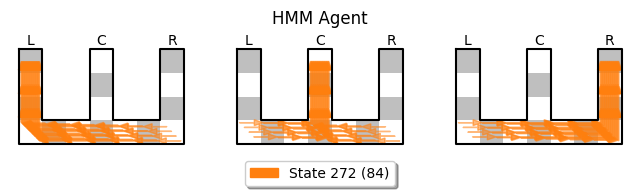

In [220]:
t = generate_trajectory_end_state(hmm_agent)
plot_trajectory(t, "HMM Agent")

In [184]:
from hippo.agents.clone_agent import CloneAgent

agent_path = hmm_path / "cscg_hippo.pkl"
tokenizer_path = hmm_path / "tokenizer.pkl"

config = {
    "cscg_path": str(agent_path),
    "tokenizer_path": str(tokenizer_path),
    "agent": {
        "reduce": True,
        "gamma": 0.5,
        "policy_len": 5,
        "random_actions": False,
        "preference_diffusion": True,
    },
}

tokenizer = load_object(config["tokenizer_path"])

fig, ax = plt.subplots(4, 5, figsize=(10, 8))
for i, a in enumerate(ax.flatten()):
    if i < len(tokenizer.codebook):
        a.imshow(tokenizer.get_observation(i) / 255.0)
        a.set_title(i)
[a.axis("off") for a in ax.flatten()]
plt.savefig(store_path / "observations.png", bbox_inches="tight")
plt.close()

cscg = load_object(config["cscg_path"])
print(cscg)

agent = CloneAgent(
    tokenizer=tokenizer,
    cscg=cscg,
    random_actions=config["agent"]["random_actions"],
    policy_len=config["agent"]["policy_len"],
    reduce=config["agent"]["reduce"],
    gamma=config["agent"]["gamma"],
    preference_diffusion=config["agent"]["preference_diffusion"],
)
agent.reset()


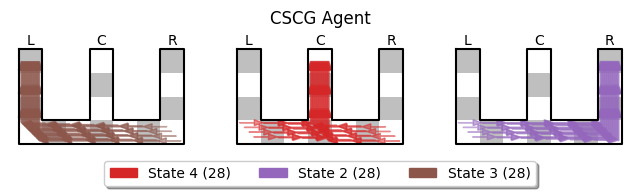

In [221]:
t = generate_trajectory_end_state(agent)
plot_trajectory(t, "CSCG Agent")

For statistics of success runs: 
look at `experiments/model-learning/evaluate_planning_and_inference_cscg.py` for cscg 
and `experiments/model_learning/evaluate_planning_and_inference_hmm.py` for the HMM. 

These generate the results summarized below: 

- CSCG: 192/192 from-to scenarios success
- HMM: 23
- HMM + Viterbi: 32/192      